# 0. Libraries and Dependencies

In [ ]:
import os

In [ ]:
# Create necessary directories (skip if created already)
for directory in ["data",
                  "data/raw",
                  "data/raw/5m",
                  "data/resampled",
                  "data/resampled/5m",
                  "data/resampled/10m",
                  "data/resampled/15m"]:
    try:
        os.mkdir(directory)
    except FileExistsError:
        continue

We're supposed to input the raw ETH, BTC and DOGE data into the folder "data/raw/5m".

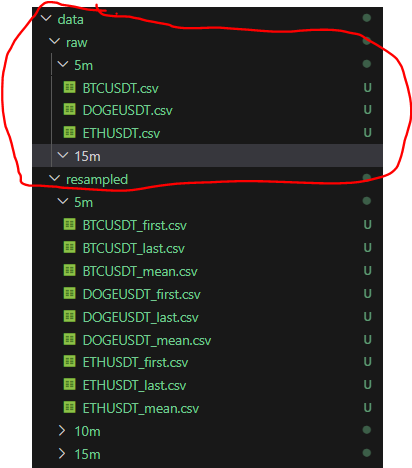

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

from typing import Callable
from scipy.stats import norm
from scipy.stats.distributions import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_validate

Make the code so that it takes as argument given some combination of the parameters.

# 1. Data Preparation

Data preparation in terms of resampling is done upfront because once done, its the raw material for the rest of the pipeline. From 1.2 onwards, we are assuming one "case" of the iterations that we will end up doing.

## 1.1 Preparation and Resampling

In [ ]:
# RESAMPLING PARAMETERS
resample_intervals: list[int] = [15]                    # New frequency of the series in minutes
resample_methods: list[str] = ['mean']      # The aggregation we are performing

data_root = "./data/"
raw_data_dir = data_root+"raw/5m/"
processed_dir = data_root+"resampled/"

In [ ]:
def resample_df(trading_df: pd.DataFrame, data_name:str, frequencies: list[int],
                resampling_methods: list[str], output_dir: str):
    """Resample the dataframe to the frequencies provided."""
    df_original = trading_df.copy()

    df_original['Time'] = pd.to_datetime(df_original['Time']) #changing the type of data to date time
    df_original.set_index('Time', inplace=True)

    # SECTION: RESAMPLING - - -
    # Create a dictionary to store resampled DataFrames
    resampled_dfs = {}

    # Iterate through resampling intervals and methods
    for interval in frequencies:
        for method in resampling_methods:
            # Resample the data with label set to 'right' and aggregate using the current method
            df_resampled = df_original.resample(f'{interval}T', label='right').agg(method)
            # Generate a unique name for each dataframe
            df_name = f'{data_name}_resampled_{interval}m_{method}'
            # Store the name in the dictionary for reference
            resampled_dfs[df_name] = df_resampled

    # SECTION: SAVE RESAMPLED DFS - - -
    for df_name, df in resampled_dfs.items():
        # Structure: Token, "resampled", time, resampling rule
        token, _, frequency, method = str(df_name).split("_")

        filename = f"{token}_{method}.csv"
        filedir = f"{output_dir}{frequency}/"

        df.to_csv(f"{filedir}{filename}", sep=",")

In [ ]:
def prepare_data(raw_directory: str, frequencies: list[int],
                resampling_methods: list[str], output_dir: str):
    """Resample series for all coins present in raw and return list of assets"""
    asset_list = []
    for asset_filename in os.listdir(raw_directory):
        try:
          asset_df = pd.read_csv(raw_directory+asset_filename)
        except IsADirectoryError:
          continue
        # Save the crypto's name
        asset_name = asset_filename.split(".")[0]
        asset_list.append(asset_name)

        # Call for its resampling
        resample_df(trading_df=asset_df, frequencies=frequencies,
                    data_name=asset_name,
                    resampling_methods=resampling_methods,
                    output_dir=output_dir)

    return asset_list

In [ ]:
assets = prepare_data(raw_directory=raw_data_dir, frequencies=resample_intervals,
                      resampling_methods=resample_methods,
                      output_dir=processed_dir)

In [ ]:
# Lists we will iterate on later
print(assets)

resample_intervals_str: list[str] = [f"{minutes}m" for minutes in resample_intervals]
print(resample_intervals_str)

['ETHUSDT', 'DOGEUSDT', 'BTCUSDT']
['15m']


## 1.2 Calculate the Expected Return

From here assume a "case" with certain parameters.

In [ ]:
processed_dir

'./data/resampled/'

In [ ]:
asset = "DOGEUSDT"
interval = "15m"
resample_method = "mean"

data_dir = f"{processed_dir}{interval}/{asset}_{resample_method}.csv"

In [ ]:
expected_return_function: Callable = lambda list_of_prices: max(list_of_prices)
tau: int = 3                      # forecasting horizon

alpha: float =  0.01             # Top alpha expected returns
stop_loss_fraction: float = 0.30  # Percentage of the price that if we see, we liquidate the position

# Hyperparameter tuning:
param_grid = {
    "n_estimators": randint(low=100, high=1000),
    "min_samples_split": randint(low=2, high=20),
    "min_impurity_decrease": uniform(loc=0.0, scale=0.5),
    "ccp_alpha": [0.0, 0.5, 1.0]
}

In [ ]:
df = pd.read_csv(data_dir)
df['Time'] = pd.to_datetime(df['Time']) #changing the type of data to date time
df.set_index('Time', inplace=True)

In [ ]:
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

In [ ]:
df.head()

,Open,High,Low,Close,Volume,LogReturn
Time,,,,,,
2023-09-01 00:15:00,0.063893,0.063973,0.063833,0.063933,1.252055e+06,NaN
2023-09-01 00:30:00,0.063980,0.064100,0.063957,0.064010,1.540832e+06,0.001198
2023-09-01 00:45:00,0.063963,0.063990,0.063900,0.063907,1.104213e+06,-0.001616
2023-09-01 01:00:00,0.063917,0.063993,0.063903,0.063950,8.048387e+05,0.000678
2023-09-01 01:15:00,0.063893,0.063933,0.063840,0.063857,9.699643e+05,-0.001461


Candle stick and Close

In [ ]:
from plotly.offline import plot
import plotly.graph_objs as go
import pandas as pd

o = df['Open'].astype(float)
h = df['High'].astype(float)
l = df['Low'].astype(float)
c = df['Close'].astype(float)

trace = go.Candlestick(
            open=o,
            high=h,
            low=l,
            close=c)
data = [trace]

plot(data, filename='go_candle4.html')

'go_candle4.html'

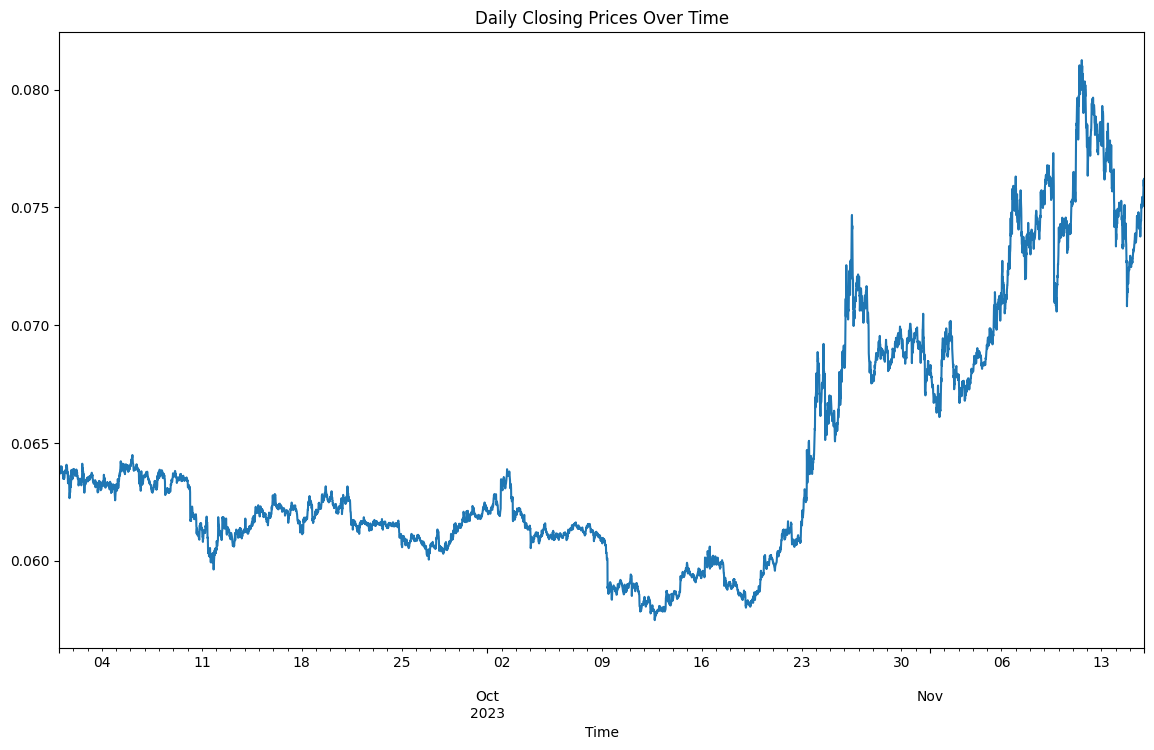

In [ ]:
df['Close'].plot(figsize=(14, 8))
plt.title('Daily Closing Prices Over Time')
plt.show()

This graph depicts the daily closing prices of a the digital coin over a specific time period. The x-axis represents time, while the y-axis displays the closing prices. The fluctuating line illustrates the variations in the closing prices, providing a visual representation of the instrument's historical price movements. Analyzing this graph can offer insights into trends, volatility, and potential patterns in the financial instrument's performance.

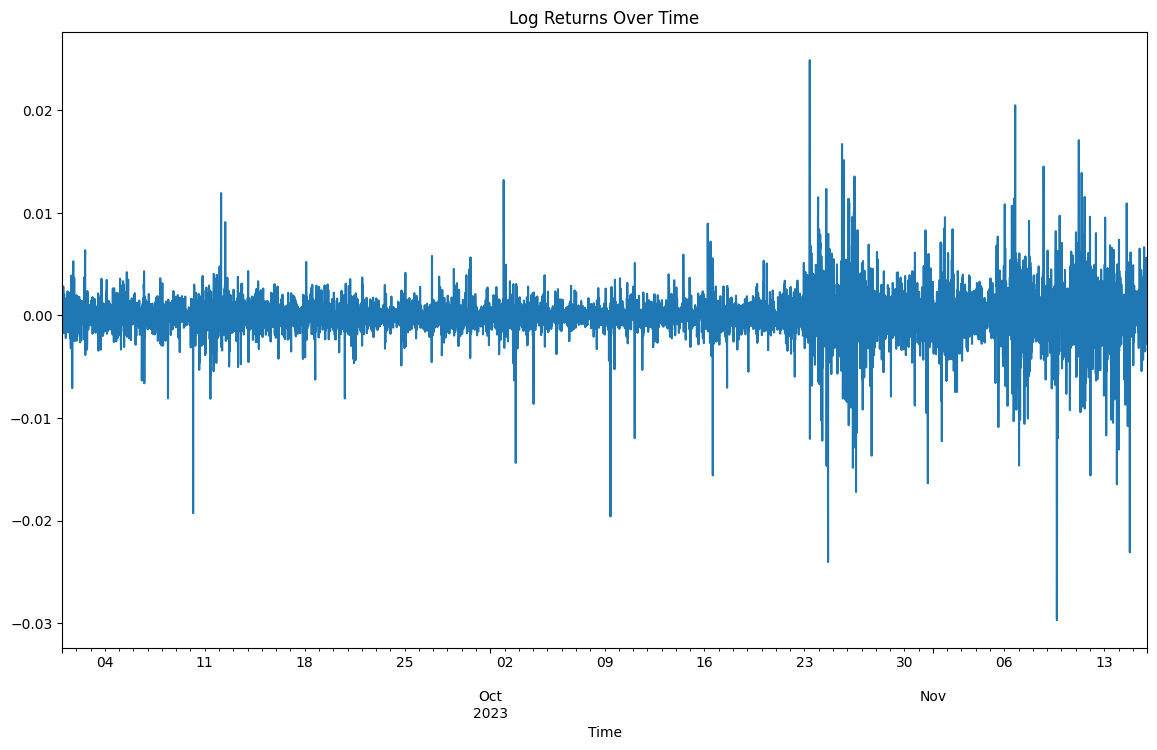

In [ ]:
df['LogReturn'].plot(figsize=(14, 8))
plt.title('Log Returns Over Time')
plt.show()

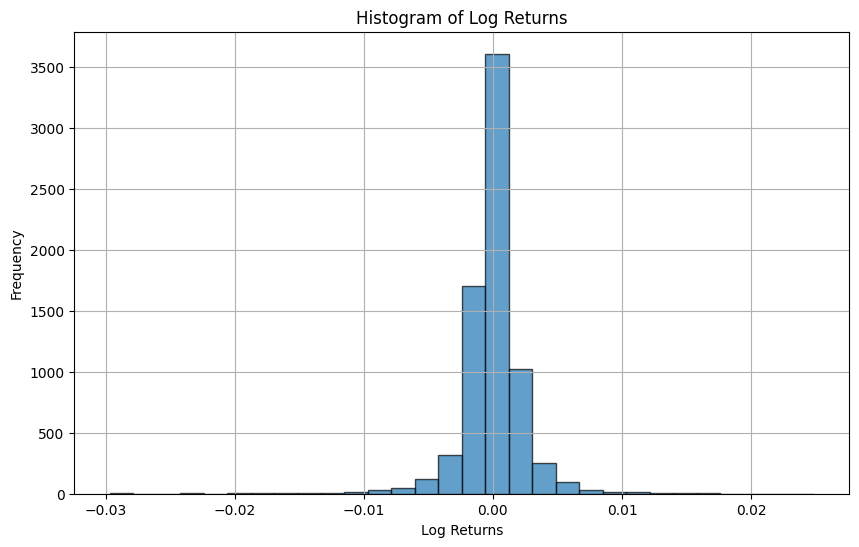

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a histogram of log returns
plt.figure(figsize=(10, 6))
plt.hist(df['LogReturn'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 1.3 Calculate the "Buy" Flag

Taking a price dataframe with a LogReturn column, apply some aggreggation
function to calculate the ExpectedReturn, and then consider flag values that
exceed some threshold.

In [ ]:
print("tau:", tau)
print("alpha:", alpha)

# expected_return_function: Callable = lambda list_of_prices: max(list_of_prices)
print("expected_return_function:", "min")

tau: 3
alpha: 0.01
expected_return_function: min


In [ ]:
df.head()

,Open,High,Low,Close,Volume,LogReturn
Time,,,,,,
2023-09-01 00:15:00,0.063893,0.063973,0.063833,0.063933,1.252055e+06,NaN
2023-09-01 00:30:00,0.063980,0.064100,0.063957,0.064010,1.540832e+06,0.001198
2023-09-01 00:45:00,0.063963,0.063990,0.063900,0.063907,1.104213e+06,-0.001616
2023-09-01 01:00:00,0.063917,0.063993,0.063903,0.063950,8.048387e+05,0.000678
2023-09-01 01:15:00,0.063893,0.063933,0.063840,0.063857,9.699643e+05,-0.001461


In [ ]:
def expected_return(asset_df: pd.DataFrame, lag_columns: list[str],
                    expected_return_function: Callable):
    """Adds ExpectedReturn column to dataframe and returns it."""
    df = asset_df.copy()
    df['ExpectedReturn'] = df[lag_columns].apply(expected_return_function, axis=1)

    return df.drop(lag_columns, axis=1)

In [ ]:
def calculate_expected_returns(asset_df: pd.DataFrame, alpha: float, tau: int, expected_return_callable: Callable):
    df = asset_df.copy()

    lags = list(range(1, tau+1))
    lag_columns = []  # List to store the names of lag columns

    # Calculate lagged returns based on the list of lags
    for lag in lags:
        lag_column_name = f'lag_{lag}'
        lag_columns.append(lag_column_name)  # Save the name of the lag column

        df[lag_column_name] = np.log(df['Close'].shift(-lag) / df['Close'])

    df['ExpectedReturn'] = df[lag_columns].apply(expected_return_callable, axis=1)
    df.drop(lag_columns, axis=1, inplace=True)


    threshold = df['ExpectedReturn'].quantile((1 - alpha))

    # Create a new column based on the condition
    df['buy_flag'] = df['ExpectedReturn'].ge(threshold).astype(int)

    return df

In [ ]:
df = calculate_expected_returns(asset_df=df, tau=tau, alpha=alpha,
                                expected_return_callable=expected_return_function)

df.head()

,Open,High,Low,Close,Volume,LogReturn,ExpectedReturn,buy_flag
Time,,,,,,,,
2023-09-01 00:15:00,0.063893,0.063973,0.063833,0.063933,1.252055e+06,NaN,0.001198,0
2023-09-01 00:30:00,0.063980,0.064100,0.063957,0.064010,1.540832e+06,0.001198,-0.000938,0
2023-09-01 00:45:00,0.063963,0.063990,0.063900,0.063907,1.104213e+06,-0.001616,0.000678,0
2023-09-01 01:00:00,0.063917,0.063993,0.063903,0.063950,8.048387e+05,0.000678,-0.001356,0
2023-09-01 01:15:00,0.063893,0.063933,0.063840,0.063857,9.699643e+05,-0.001461,0.000104,0


<Axes: xlabel='Time'>

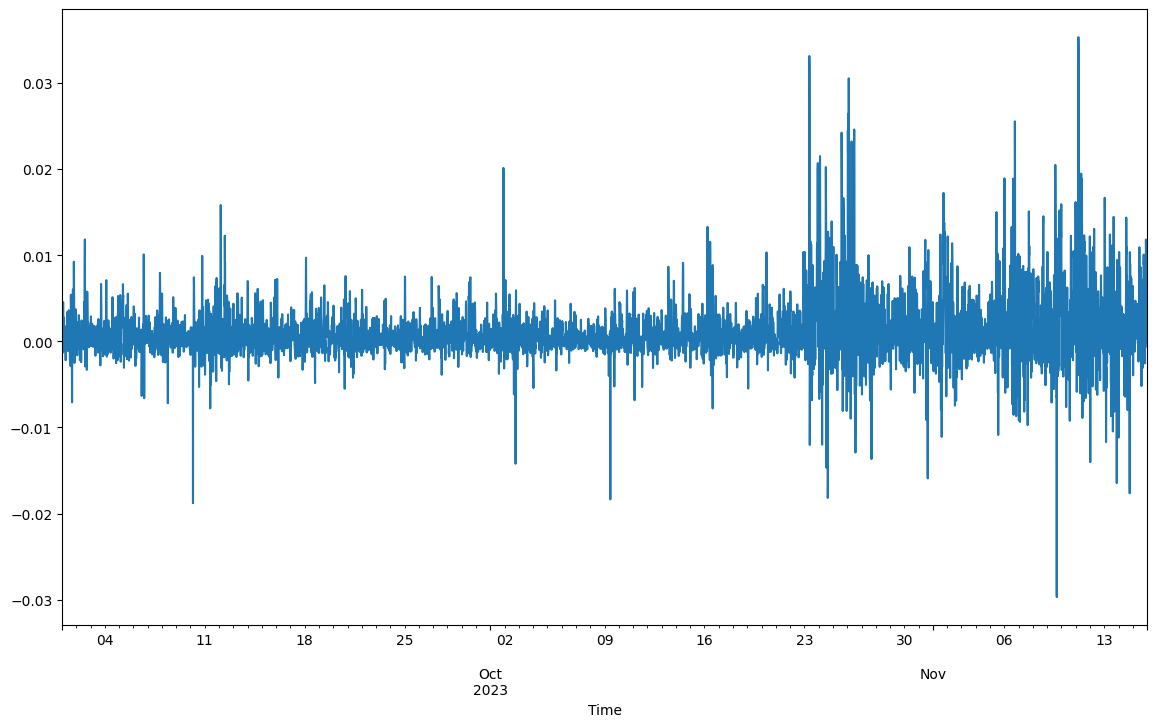

In [ ]:
df['ExpectedReturn'].plot(figsize=(14,8))

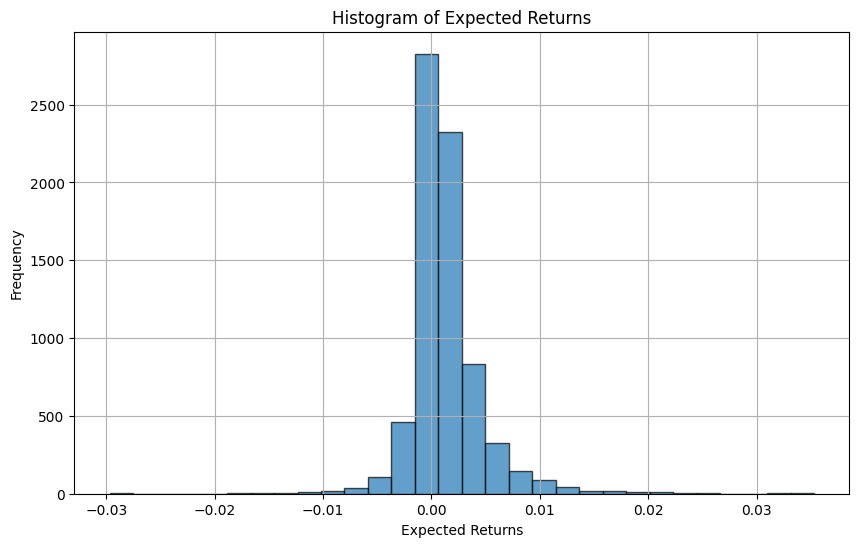

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a histogram of log returns
plt.figure(figsize=(10, 6))
plt.hist(df['ExpectedReturn'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Expected Returns')
plt.xlabel('Expected Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

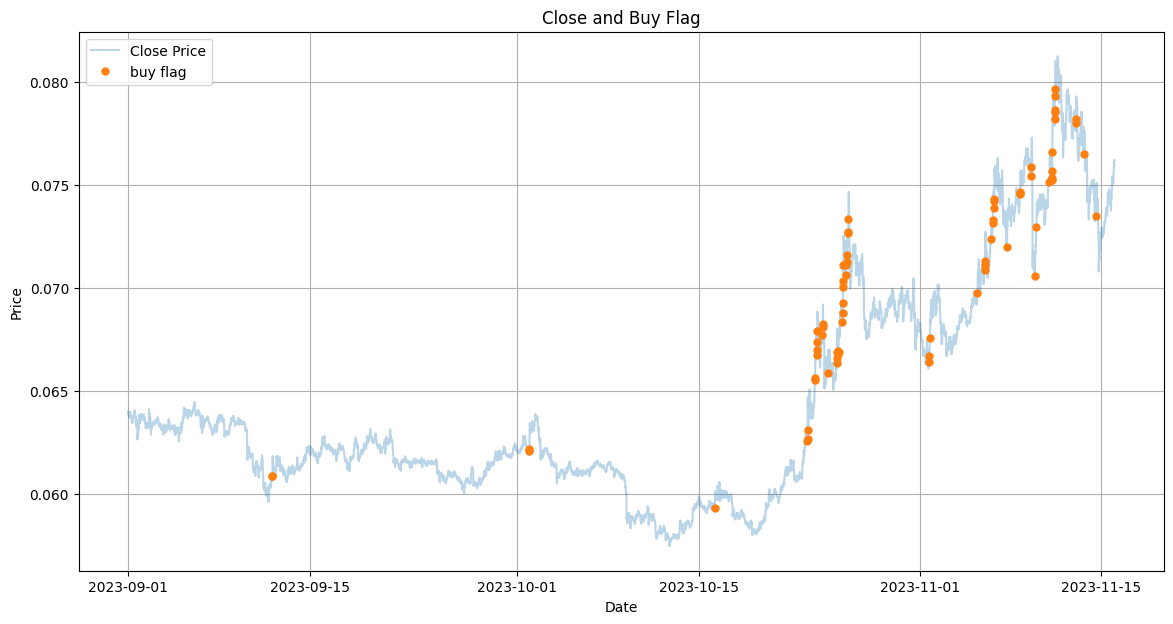

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.3)
for pattern in ['buy_flag']:
    plt.plot(df[df[pattern] != 0].index, df['Close'][df[pattern] != 0], 'o', label=pattern.replace('_', ' '), markersize=5)

plt.title('Close and Buy Flag')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 2. Feature Engineering

In [ ]:
# Input: Dataframe with everything before it
# Output: Dataframe with everything before it + features (calculated ones and the lags of the target)

In [ ]:
def var_cov_var(P, c, mu, sigma):
    # Calculate the Value-at-Risk using the Variance-Covariance method
    # P: Portfolio value, c: Confidence level, mu: Mean of returns, sigma: Standard deviation of returns
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

In [ ]:
def RSI(prices, n=9):
    # Calculate the Relative Strength Index (RSI) for a given series of prices
    # prices: Closing prices, n: Period for RSI calculation (default is 9)
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    down = -seed[seed<0].sum()/n
    up = seed[seed>=0].sum()/n
    rs = up/down
    rsi = np.zeros(len(prices))
    rsi[:n] = 100 - 100/(1 + rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta

        up = float((up*(n-1) + upval)/n)
        down = float((down*(n-1) + downval)/n + 0.00001)
        rs = up/down
        rsi[i] = 100 - 100/(1 + rs)

    return rsi

In [ ]:
def add_variables(asset_df):
    df = asset_df.copy()
    # List of variables to be added to the dataframe
    X_final_variables = ['Open_normalized', 'High_normalized', 'Close_normalized', 'Low_normalized',
                         'Open_MA_10', 'High_MA_10', 'Low_MA_10', 'Close_MA_10', 'Volume_MA_10', 'DayRange_MA_10',
                         'Open_MA_20', 'High_MA_20', 'Low_MA_20', 'Close_MA_20', 'Volume_MA_20', 'DayRange_MA_20',
                         'Open_MA_50', 'High_MA_50', 'Low_MA_50', 'Close_MA_50', 'Volume_MA_50', 'DayRange_MA_50',
                         'Open_MA_100', 'High_MA_100', 'Low_MA_100', 'Close_MA_100', 'Volume_MA_100', 'DayRange_MA_100',
                         'Open_MA_200', 'High_MA_200', 'Low_MA_200', 'Close_MA_200', 'Volume_MA_200', 'DayRange_MA_200',
                         '10_daysRange', '20_daysRange', '50_daysRange', '100_daysRange', '200_daysRange',
                         'num_consec_days_up', 'num_consec_days_down', 'rsi_5', 'rsi_9', 'rsi_14', 'rsi_18', 'rets',
                         'rets_mean', 'rets_sigma', 'VaR']

    # Initialize each variable to 0 if it doesn't exist
    for each_var in X_final_variables:
        try:
            df[each_var]
        except:
            df[each_var] = 0

    # Calculate the daily range
    df['DayRange'] = df['High'] - df['Low']

    # Normalize open, high, close, and low based on the low of the first day
    df['Open_normalized'] = df['Open'] / df['Low'].iloc[0]
    df['High_normalized'] = df['High'] / df['Low'].iloc[0]
    df['Close_normalized'] = df['Close'] / df['Low'].iloc[0]
    df['Low_normalized'] = df['Low'] / df['Low'].iloc[0]

    # Calculate various moving averages and ranges
    print("computing 10, 20, 50, 100 and 200 days moving average for variables: Open, High, Low, Close, Volume, DayRange")
    for lag in (10, 20, 50, 100, 200):
        df["Open_MA_" + str(lag)] = df["Open"].rolling(window=lag).mean()
        df["High_MA_" + str(lag)] = df["High"].rolling(window=lag).mean()
        df["Low_MA_" + str(lag)] = df["Low"].rolling(window=lag).mean()
        df["Close_MA_" + str(lag)] = df["Close"].rolling(window=lag).mean()
        df["Volume_MA_" + str(lag)] = df["Volume"].rolling(window=lag).mean()
        df["DayRange_MA_" + str(lag)] = df["DayRange"].rolling(window=lag).mean()

    # Calculate the 10, 20, 50, 100, and 200 days range
    print("and also, the 10, 20, 50, 100 and 200 days range")
    for lag in (10, 20, 50, 100, 200):
        df[str(lag) + "_daysRange"] = df["High"].rolling(window=lag).max() - df["Low"].rolling(window=lag).min()

    # Calculate RSI for different periods
    for period in range(1, 21):
        df["rsi_"+str(period)] = RSI(df ['Close'], period)

    # Calculate daily returns and Value at Risk (VaR)
    df["rets"] = df["Close"].pct_change()
    P = 1000   # 1,000 USD
    c = 0.99  # 99% confidence interval
    df["rets_mean"] = df["rets"].rolling(window=10).mean()
    df["rets_sigma"] = df["rets"].rolling(window=10).std()
    df["VaR"] = np.vectorize(var_cov_var)(P, c, df["rets_mean"], df["rets_sigma"])

    # Drop rows with NaN values after adding new variables
    df.dropna(inplace=True)

    # Additional calculations for growth and consecutive days
    df['growth'] = 0
    df.loc[df["Close"] > df["Close"].shift(1), 'growth'] = 1

    df['num_consec_days_up'] = df["growth"].groupby((df["growth"] != df["growth"].shift()).cumsum()).cumcount()
    df['num_consec_days_up'] += 1
    df.loc[df['growth'] == 0.0, 'num_consec_days_up'] = 0

    df['num_consec_days_down'] = df["growth"].groupby((df["growth"] != df["growth"].shift()).cumsum()).cumcount()
    df['num_consec_days_down'] += 1
    df.loc[df['growth'] == 1.0, 'num_consec_days_down'] = 0

    return df

In [ ]:
df = add_variables(df)
df.head()

computing 10, 20, 50, 100 and 200 days moving average for variables: Open, High, Low, Close, Volume, DayRange
and also, the 10, 20, 50, 100 and 200 days range


<ipython-input-69-29ff1675308d>:8: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-69-29ff1675308d>:8: RuntimeWarning:

divide by zero encountered in double_scalars



,Open,High,Low,Close,Volume,LogReturn,ExpectedReturn,buy_flag,Open_normalized,High_normalized,...,rsi_10,rsi_11,rsi_12,rsi_13,rsi_15,rsi_16,rsi_17,rsi_19,rsi_20,growth
Time,,,,,,,,,,,,,,,,,,,,,
2023-09-03 02:00:00,1633.480000,1633.670000,1633.270000,1633.453333,106.703700,-0.000386,0.000700,0,0.991731,0.991846,...,37.624203,38.690981,39.621183,40.438315,41.807243,42.387331,42.912023,43.825372,44.225331,0
2023-09-03 02:15:00,1633.263333,1633.516667,1632.483333,1633.273333,261.852000,-0.000110,0.000810,0,0.991599,0.991753,...,36.715595,37.848122,38.835790,39.703588,41.157610,41.773705,42.330870,43.300453,43.724936,0
2023-09-03 02:30:00,1634.216667,1634.673333,1634.043333,1634.596667,176.522133,0.000810,0.000198,0,0.992178,0.992455,...,47.137367,47.152031,47.220450,47.320542,47.569085,47.704638,47.842651,48.117177,48.250554,1
2023-09-03 02:45:00,1634.436667,1634.643333,1634.066667,1634.380000,138.264433,-0.000133,0.000330,0,0.992312,0.992437,...,45.765589,45.913493,46.091218,46.282815,46.676222,46.870169,47.059529,47.420280,47.590270,0
2023-09-03 03:00:00,1634.500000,1634.593333,1634.120000,1634.450000,122.433267,0.000043,0.000288,0,0.992350,0.992407,...,46.325366,46.412787,46.540874,46.691072,47.019557,47.187645,47.354460,47.677844,47.832191,1


# 3. Back Testing and Model Training

First we have to identify the features and identify the proper matrices.

In [ ]:
target_colname = 'buy_flag'
numeric_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Open_normalized',
                    'High_normalized', 'Close_normalized', 'Low_normalized',
                    'Open_MA_10', 'High_MA_10', 'Low_MA_10', 'Close_MA_10',
                    'Volume_MA_10', 'DayRange_MA_10', 'Open_MA_20',
                    'High_MA_20', 'Low_MA_20', 'Close_MA_20', 'Volume_MA_20',
                    'DayRange_MA_20', 'Open_MA_50', 'High_MA_50', 'Low_MA_50',
                    'Close_MA_50', 'Volume_MA_50', 'DayRange_MA_50',
                    'Open_MA_100', 'High_MA_100', 'Low_MA_100', 'Close_MA_100',
                    'Volume_MA_100', 'DayRange_MA_100', 'Open_MA_200',
                    'High_MA_200', 'Low_MA_200', 'Close_MA_200',
                    'Volume_MA_200', 'DayRange_MA_200', '10_daysRange',
                    '20_daysRange', '50_daysRange', '100_daysRange',
                    '200_daysRange', 'num_consec_days_up',
                    'num_consec_days_down', 'rsi_5', 'rsi_9',
                    'rsi_14', 'rsi_18', 'rets', 'rets_mean', 'rets_sigma',
                    'VaR', 'DayRange', 'rsi_1', 'rsi_2', 'rsi_3', 'rsi_4',
                    'rsi_6', 'rsi_7', 'rsi_8', 'rsi_10', 'rsi_11', 'rsi_12',
                    'rsi_13', 'rsi_15', 'rsi_16', 'rsi_17', 'rsi_19', 'rsi_20']
categorical_features = ['growth']

In [ ]:
X_categorical = df[categorical_features]

X_categorical

,growth
Time,
2023-09-02 09:20:00,0
2023-09-02 09:30:00,1
2023-09-02 09:40:00,0
2023-09-02 09:50:00,1
2023-09-02 10:00:00,1
...,...
2023-11-15 23:10:00,0
2023-11-15 23:20:00,0
2023-11-15 23:30:00,1


In [ ]:
X = pd.concat([df[numeric_features], X_categorical], axis=1)
X.head()

,Open,High,Low,Close,Volume,Open_normalized,High_normalized,Close_normalized,Low_normalized,Open_MA_10,...,rsi_10,rsi_11,rsi_12,rsi_13,rsi_15,rsi_16,rsi_17,rsi_19,rsi_20,growth
Time,,,,,,,,,,,,,,,,,,,,,
2023-09-02 09:20:00,1632.02,1633.49,1632.02,1632.93,260.2280,0.990406,0.991298,0.990958,0.990406,1631.527,...,61.092670,59.953692,59.024250,58.260336,57.094907,56.642619,56.252070,55.605113,55.329803,0
2023-09-02 09:30:00,1633.76,1633.77,1632.93,1633.39,380.6402,0.991461,0.991468,0.991237,0.990958,1631.679,...,63.923938,62.594709,61.484227,60.549940,59.077933,58.489413,57.973534,57.106305,56.734713,1
2023-09-02 09:40:00,1632.84,1632.96,1632.34,1632.76,424.8534,0.990903,0.990976,0.990855,0.990600,1631.751,...,57.548092,56.934992,56.420629,55.990306,55.323316,55.060811,54.831534,54.442743,54.271873,0
2023-09-02 09:50:00,1633.66,1634.60,1633.35,1633.54,465.2992,0.991401,0.991971,0.991328,0.991213,1632.016,...,62.668441,61.654957,60.781225,60.025945,58.795330,58.288168,57.835916,57.058626,56.718866,1
2023-09-02 10:00:00,1633.92,1634.13,1633.43,1633.73,226.6740,0.991559,0.991686,0.991443,0.991261,1632.155,...,63.847745,62.748087,61.796214,60.969605,59.613708,59.051527,58.548786,57.682723,57.304046,1


In [ ]:
y = df[target_colname]
y.head()

Time
2023-09-02 09:20:00    0
2023-09-02 09:30:00    0
2023-09-02 09:40:00    0
2023-09-02 09:50:00    0
2023-09-02 10:00:00    0
Name: buy_flag, dtype: int64

## 3.1 Cross Validation and Hyperparameter Tuning

Prepare the time series cross-validation.

In [ ]:
ts_cv = TimeSeriesSplit(n_splits=5)

all_splits = ts_cv.split(X=X, y=y)

In [ ]:
base_forest = RandomForestClassifier(class_weight="balanced")

In [ ]:
def evaluate_model(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=['f1', 'roc_auc']
    )
    f1 = cv_results['test_f1']
    roc_auc = cv_results['test_roc_auc']

    print(
        f"F1 Score:     {f1.mean():.3f} +/- {f1.std():.3f}\n"
        f"ROC Area Under the Curve: {roc_auc.mean():.3f} +/- {roc_auc.std():.3f}"
    )

    return cv_results

In [ ]:
evaluate_model(base_forest, X=X, y=y, cv=ts_cv)

F1 Score:     0.000 +/- 0.000
ROC Area Under the Curve: 0.531 +/- 0.044


{'fit_time': array([0.53833199, 1.30725026, 2.7821939 , 3.14277864, 4.43058348]),
 'score_time': array([0.04533315, 0.05811357, 0.07400012, 0.04569077, 0.04923987]),
 'test_f1': array([0., 0., 0., 0., 0.]),
 'test_roc_auc': array([0.57183854, 0.47710561, 0.59006972, 0.49312981, 0.52391178])}

## 3.2 Train the best model found by the Hyperparameter Tuning

In [ ]:
param_grid

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x787cd4db3850>,
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x787cd4db2c80>,
 'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x787cd4db3190>,
 'ccp_alpha': [0.0, 0.5, 1.0]}

In [ ]:
search_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=1,
    scoring='f1',
    cv = ts_cv,
    verbose=2
)

In [ ]:
search_cv.fit(X=X, y=y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ccp_alpha=1.0, min_impurity_decrease=0.23120305409997, min_samples_split=16, n_estimators=635; total time=   1.9s
[CV] END ccp_alpha=1.0, min_impurity_decrease=0.23120305409997, min_samples_split=16, n_estimators=635; total time=   2.7s
[CV] END ccp_alpha=1.0, min_impurity_decrease=0.23120305409997, min_samples_split=16, n_estimators=635; total time=   4.2s
[CV] END ccp_alpha=1.0, min_impurity_decrease=0.23120305409997, min_samples_split=16, n_estimators=635; total time=   5.3s
[CV] END ccp_alpha=1.0, min_impurity_decrease=0.23120305409997, min_samples_split=16, n_estimators=635; total time=   5.5s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(), n_iter=1,
                   param_distributions={'ccp_alpha': [0.0, 0.5, 1.0],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x787cd4db3190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x787cd4db2c80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x787cd4db3850>},
                   scoring='f1', verbose=2)

In [ ]:
best_params = search_cv.best_params_

best_params

{'ccp_alpha': 1.0,
 'min_impurity_decrease': 0.23120305409997,
 'min_samples_split': 16,
 'n_estimators': 635}

In [ ]:
final_model = RandomForestClassifier(
    ccp_alpha=best_params['ccp_alpha'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)

In [ ]:
evaluate_model(final_model, X=X, y=y, cv=ts_cv)

F1 Score:     0.000 +/- 0.000
ROC Area Under the Curve: 0.500 +/- 0.000


{'fit_time': array([1.75151348, 2.62497234, 3.53835845, 5.71531153, 5.41054845]),
 'score_time': array([0.17671752, 0.16853738, 0.17168093, 0.1754303 , 0.16585326]),
 'test_f1': array([0., 0., 0., 0., 0.]),
 'test_roc_auc': array([0.5, 0.5, 0.5, 0.5, 0.5])}

In [ ]:
final_model.fit(X=X, y=y)       # Use this to .predict() for validation

RandomForestClassifier(ccp_alpha=1.0, min_impurity_decrease=0.23120305409997,
                       min_samples_split=16, n_estimators=635)